# RNN Modeling of Weight Data

## Setup

In [1]:
from wlp_utils import ml_utils

import importlib
import datetime

%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from ggplot import *

Using TensorFlow backend.
/Users/jamieinfinity/.local/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/jamieinfinity/.local/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [209]:
importlib.reload(ml_utils)

<module 'wlp_utils.ml_utils' from '/Users/jamieinfinity/Projects/WorldLine/worldline-wgt/server/src/wlp_utils/ml_utils.py'>

## Data

In [2]:
this=ml_utils.get_model_data_df('2015-09-16', '2020-01-01')
this.tail(5)

,Weight,Steps,Calories
Date,,,
2017-10-26,169.2,14647.0,2598.0
2017-10-27,169.9,10929.0,2514.0
2017-10-28,170.8,8480.0,3335.0
2017-10-29,170.7,16671.0,2864.0
2017-10-30,171.8,6383.0,1789.0


In [3]:
len(this)

776

In [75]:
x_train, y_train, dates = ml_utils.get_model_data_seq('2015-09-16', '2016-9-30', 10, shuffle=False)

In [76]:
len(x_train)

371

In [188]:
WGT_SCALE_FACTOR = 170
NUM_FEATURES = 3
SEQUENCE_LENGTH = 28
TEST_DAYS = 100
HOLDOUT_DAYS = 0
NFOLDS = 5

[(features_train, target_train, dates_train), 
 (features_test, target_test, dates_test), 
 (features_holdout, target_holdout, dates_holdout)] = ml_utils.get_model_data_splits(
    sequence_length=SEQUENCE_LENGTH, 
    holdout_days=HOLDOUT_DAYS, 
    test_days=TEST_DAYS,
    train_shuffle=False
)

In [133]:
len(features_train)

648

## Model Building

### Parameters

In [198]:
model_params = {
    'num_features':NUM_FEATURES,
    'sequence_length':SEQUENCE_LENGTH,
    'lstm_sizes':[128],
    'lstm_dropout_rates':[0]
}
# model_params = {
#     'num_features':NUM_FEATURES,
#     'sequence_length':SEQUENCE_LENGTH,
#     'lstm_sizes':[64, 32, 16],
#     'lstm_dropout_rates':[0.15, 0.1, 0.05]
# }
training_params = {
    'verboseness':0,
    'loss_function':'mean_absolute_error', # 'mean_absolute_percentage_error'  # mean_absolute_error
    'optimization_method':'adam',
    'batch_size':5,
    'epochs':1000,
    'early_stopping_patience':5,
    'min_delta':0.0005
}

In [113]:
def get_params(vals):
    (lstm_sizes, lstm_dropout_rates, batch_size) = vals
    return (
        {
            'num_features':NUM_FEATURES,
            'sequence_length':SEQUENCE_LENGTH,
            'lstm_sizes':lstm_sizes,
            'lstm_dropout_rates':lstm_dropout_rates
        },
        {
            'verboseness':0,
            'loss_function':'mean_absolute_error',
            'optimization_method':'adam',
            'batch_size':batch_size,
            'epochs':1000,
            'early_stopping_patience':5,
            'min_delta':0.001
        }
    )

def generate_param_sets(lstm_set, dropout_set, batch_size_set):
    parms = []
    for lstm in lstm_set:
        for dropout in dropout_set:
            for batch in batch_size_set:
                parms.append((lstm, dropout, batch))
    return parms

### Train CV models

In [51]:
importlib.reload(ml_utils)

<module 'wlp_utils.ml_utils' from '/Users/jamieinfinity/Projects/WorldLine/worldline-wgt/server/src/wlp_utils/ml_utils.py'>

In [199]:
results = ml_utils.train_cv_models(model_params,
                          training_params,
                          [(features_train, target_train), (features_test, target_test)],
                          n_splits=NFOLDS,
                          random_state=42, 
                          early_stopping_data=(features_test, target_test)
                         )

Fold 0 
losses - train: 0.009824, val: 0.009973, test: 0.017704
Fold 1 
losses - train: 0.009236, val: 0.009106, test: 0.006184
Fold 2 
losses - train: 0.006341, val: 0.006238, test: 0.007774
Fold 3 
losses - train: 0.006134, val: 0.005870, test: 0.007644
Fold 4 
losses - train: 0.007906, val: 0.007904, test: 0.007637


In [200]:
models = results['models']
histories = results['histories']
losses = results['losses']
indices = results['cv_indices']

In [201]:
[x.epoch[-1] for x in histories]

[14, 23, 18, 26, 18]

In [202]:
np.array([x['test'] for x in results['losses']])*WGT_SCALE_FACTOR

array([ 3.00975558,  1.05124216,  1.32151362,  1.2995263 ,  1.29823069])

### Hyperparameter grid search

In [49]:
# param_sets = generate_param_sets(
#     [[32], [64], [128], [256], [512]], 
#     [[0], [0.1], [0.2], [0.5]], 
#     [5, 10, 20]
# )
# param_sets = generate_param_sets(
#     [[32], [64], [128], [256], [512]], 
#     [[0]], 
#     [5]
# )
param_sets = generate_param_sets(
    [[64, 2]], 
    [[0, 0]], 
    [5]
)
param_sets = [get_params(x) for x in param_sets]

In [50]:
all_results = []
for params in param_sets:
    print (params[0]['lstm_sizes'], params[0]['lstm_dropout_rates'], params[1]['batch_size'])
    results = ml_utils.train_cv_models(params[0],
                          params[1],
                          [(features_train, target_train), (features_test, target_test)],
                          n_splits=NFOLDS,
                          random_state=1, 
                          early_stopping_data=(features_test, target_test)
                         )
    all_results.append(results)

[64, 2] [0, 0] 5
Fold 0 
losses - train: 0.017660, val: 0.017586, test: 0.019122
Fold 1 
losses - train: 0.063219, val: 0.056793, test: 0.052103
Fold 2 
losses - train: 0.060488, val: 0.080772, test: 0.053923
Fold 3 
losses - train: 0.063198, val: 0.056594, test: 0.053050
Fold 4 
losses - train: 0.061932, val: 0.068034, test: 0.053991
Fold 5 
losses - train: 0.018463, val: 0.017846, test: 0.019644
Fold 6 
losses - train: 0.019786, val: 0.019217, test: 0.021563
Fold 7 
losses - train: 0.016861, val: 0.016837, test: 0.018864
Fold 8 
losses - train: 0.064008, val: 0.049678, test: 0.051708
Fold 9 
losses - train: 0.061993, val: 0.067488, test: 0.054307


In [51]:
param_losses = []
for i in range(len(all_results)):
    mae = np.array([x['val'] for x in all_results[i]['losses']]).mean()*WGT_SCALE_FACTOR
    param_losses.append(mae)

In [52]:
param_losses

[2.2542281154279928]

In [34]:
param_losses

[0.84528966720039056, 0.85418936434543802]

### Train bootstrapped models

In [153]:
importlib.reload(ml_utils)

<module 'wlp_utils.ml_utils' from '/Users/jamieinfinity/Projects/WorldLine/worldline-wgt/server/src/wlp_utils/ml_utils.py'>

In [ ]:
results = ml_utils.train_bs_models(model_params,
                          training_params,
                          [(features_train, target_train), (features_test, target_test)],
                          n_samples=100,
                          sample_size=len(features_train)
                         )

Sample 0 
losses - train: 0.024022, test: 0.028228
Sample 1 
losses - train: 0.022010, test: 0.021489
Sample 2 
losses - train: 0.022238, test: 0.024222
Sample 3 
losses - train: 0.022849, test: 0.023124
Sample 4 
losses - train: 0.023783, test: 0.026316
Sample 5 
losses - train: 0.020881, test: 0.023125
Sample 6 
losses - train: 0.023252, test: 0.023316
Sample 7 
losses - train: 0.021584, test: 0.021281
Sample 8 
losses - train: 0.019991, test: 0.021168
Sample 9 
losses - train: 0.021832, test: 0.024204
Sample 10 
losses - train: 0.022840, test: 0.021919
Sample 11 
losses - train: 0.023864, test: 0.024176
Sample 12 
losses - train: 0.022104, test: 0.024726
Sample 13 
losses - train: 0.022580, test: 0.023187
Sample 14 
losses - train: 0.021721, test: 0.022652
Sample 15 
losses - train: 0.020943, test: 0.023182
Sample 16 
losses - train: 0.023329, test: 0.024099
Sample 17 
losses - train: 0.022004, test: 0.024416
Sample 18 
losses - train: 0.021630, test: 0.024292
Sample 19 
losses - tr

In [6]:
all_models = results['models']
histories = results['histories']
losses = results['losses']
indices = results['bs_indices']

In [7]:
[x.epoch[-1] for x in histories]

[18,
 17,
 19,
 16,
 13,
 16,
 13,
 20,
 13,
 20,
 15,
 17,
 12,
 15,
 13,
 14,
 12,
 13,
 16,
 14,
 17,
 15,
 12,
 14,
 17,
 12,
 15,
 12,
 18,
 14,
 14,
 19,
 13,
 12,
 15,
 18,
 16,
 13,
 15,
 18,
 12,
 11,
 18,
 15,
 20,
 12,
 15,
 13,
 15,
 17]

In [8]:
np.array([x['test'] for x in results['losses']]).mean()*WGT_SCALE_FACTOR

0.96292937389360012

In [9]:
np.array([x['test'] for x in results['losses']]).mean()*WGT_SCALE_FACTOR

0.96292937389360012

## Errors Over Sequence of Days

In [203]:
errors_samples = []
abs_errors_samples = []
for index in range(len(models)): 
    train_index = indices[index]
    # X, y = features_train[train_index], target_train[train_index]
    X, y = features_test, target_test
    errors = np.array([0 for i in range(0,len(X[0]))])
    abs_errors = np.array([0 for i in range(0,len(X[0]))])
    model = models[index]
    for i in range(0, len(X)):
        x_in = np.array([X[i]])
        pred = model.predict(x_in)[0]
        true = y[i]
        errors = errors + (pred-true).reshape(len(X[0]))
        abs_errors = abs_errors + np.abs(pred-true).reshape(len(X[0]))
    errors = WGT_SCALE_FACTOR*errors/len(X)
    abs_errors = WGT_SCALE_FACTOR*abs_errors/len(X)
    errors_samples.append(errors)
    abs_errors_samples.append(abs_errors)

In [133]:
# pick only 'best' models
errs_last = [x[-1] for x in errors_samples]
abs_errs_last = [x[-1] for x in abs_errors_samples]
err_inds = [[i, errs_last[i], abs_errs_last[i]] for i in range(len(all_models))]
err_inds = sorted(err_inds, key=(lambda x:np.fabs(x[1])))
ind_max = 26
print(np.mean([x[1] for x in err_inds[0:ind_max]]))
inds_sorted = [x[0] for x in err_inds[0:ind_max]]
models = [all_models[i] for i in inds_sorted]

0.00423557290468


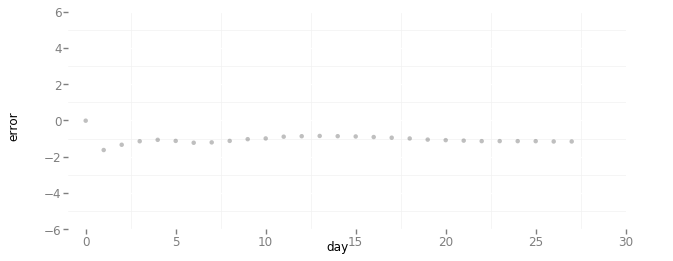

In [206]:
errs = errors_samples[3]
errors_df = pd.DataFrame({'day':range(0,len(X[0])), 'error':errs})

p = ggplot(aes(x='day', y='error'), data=errors_df) +\
geom_point(color='black', alpha=0.25)  +\
scale_x_continuous(limits=(-1, 30)) +\
scale_y_continuous(limits=(-6, 6)) +\
theme_bw()

p.save('test.png', width=10, height=4)

## Errors Over Data Set

### Training set

In [210]:
weight_target = [ml_utils.weight_inverse_transform(x[0]) for x in target_train[:,-1]]
dates_target = [x + np.timedelta64(1, 'D') for x in dates_train[:,-1]]
weight_target_df = pd.DataFrame({'date': dates_target, 'weight': weight_target})

(dates_target_min, dates_target_max) = (dates_target[0]-np.timedelta64(5,'D'), dates_target[-1]+np.timedelta64(5,'D'))

weight_pred_folds = []
for fold in range(len(models)):
    model = models[fold]
    weight_pred = [model.predict(np.array([x]))[0][-1][0] for x in features_train]
    weight_pred = [ml_utils.weight_inverse_transform(x) for x in weight_pred]
    weight_pred_folds.append(weight_pred)
    
weight_pred_folds = np.array(weight_pred_folds).transpose()
weight_pred_mean = weight_pred_folds.mean(axis=1)
weight_pred_std = weight_pred_folds.std(axis=1)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

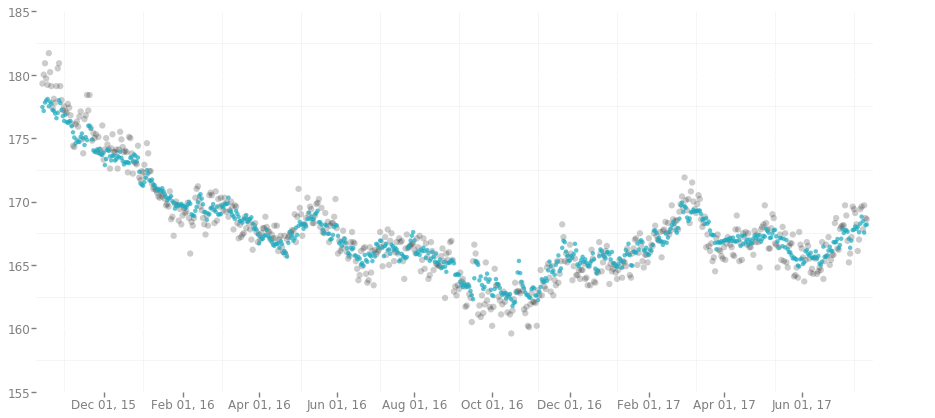

In [211]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=20) +\
scale_y_continuous(limits=(155, 185)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=15, height=7)

#geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.5, data=weight_pred_df) +\

### Test set

In [127]:
weight_target = [ml_utils.weight_inverse_transform(x[0]) for x in target_test[:,-1]]
dates_target = [x + np.timedelta64(1, 'D') for x in dates_test[:,-1]]
days_target = list(range(len(dates_target)))
weight_target_df = pd.DataFrame({'day':days_target, 'date': dates_target, 'weight': weight_target})

(dates_target_min, dates_target_max) = (dates_target[0]-np.timedelta64(5,'D'), dates_target[-1]+np.timedelta64(5,'D'))

weight_pred_folds = []
for fold in range(len(models)):
    model = models[fold]
    weight_pred = [model.predict(np.array([x]))[0][-1][0] for x in features_test]
    weight_pred = [ml_utils.weight_inverse_transform(x) for x in weight_pred]
    weight_pred_folds.append(weight_pred)
    
weight_pred_folds = np.array(weight_pred_folds).transpose()
weight_pred_mean = weight_pred_folds.mean(axis=1)
weight_pred_std = weight_pred_folds.std(axis=1)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'day':days_target, 'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

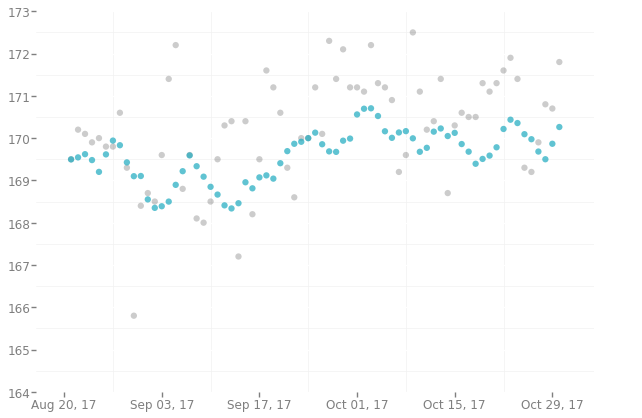

In [128]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=40) +\
scale_y_continuous(limits=(164, 173)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=10, height=7)

# geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.5, data=weight_pred_df) +\

## Forecasted Predictions

### Training set

In [212]:
weight_target = [ml_utils.weight_inverse_transform(x[0]) for x in target_train[:,-1]]
dates_target = [x + np.timedelta64(1, 'D') for x in dates_train[:,-1]]
weight_target_df = pd.DataFrame({'date': dates_target, 'weight': weight_target})

(dates_target_min, dates_target_max) = (dates_target[0]-np.timedelta64(5,'D'), dates_target[-1]+np.timedelta64(5,'D'))

In [213]:
weight_pred_folds = []
for fold in range(len(models)):
    model = models[fold]
    rolling_sequence = features_train[0]
    weight_pred = []
    for t in range(1, len(dates_target)):
        pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
        weight_pred.append(pred)
        features_next = features_train[t][-1]
        features_next[0] = pred
#        rolling_sequence = features_train[t][0:(SEQUENCE_LENGTH-1)]
        rolling_sequence = rolling_sequence[1:SEQUENCE_LENGTH]
        rolling_sequence = np.append(rolling_sequence, np.array([features_next]), axis=0)
    final_pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
    weight_pred.append(final_pred)
    weight_pred = [ml_utils.weight_inverse_transform(x) for x in weight_pred]
    weight_pred_folds.append(weight_pred)

weight_pred_folds = np.array(weight_pred_folds).transpose()
weight_pred_mean = weight_pred_folds.mean(axis=1)
weight_pred_std = weight_pred_folds.std(axis=1)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'date':dates_target, 
                               'weight':weight_pred_mean, 
                               'wmin':weight_pred_min, 
                               'wmax':weight_pred_max})

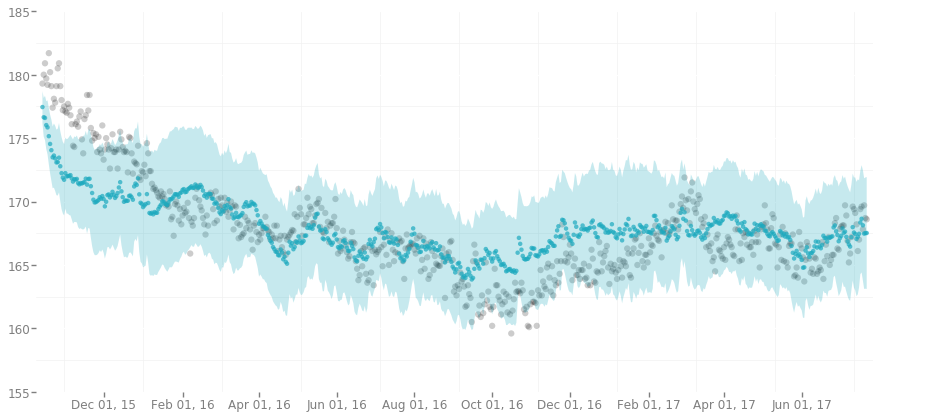

In [214]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=20) +\
geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.25, data=weight_pred_df) +\
scale_y_continuous(limits=(155, 185)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=15, height=7)

In [215]:
weight_pred_mean = []
weight_pred_std = []
rolling_sequence = features_train[0]
for t in range(1, len(dates_target)):
    weight_pred_folds = np.array([])
    for fold in range(len(models)):
        model = models[fold]
        pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
        weight_pred_folds = np.append(weight_pred_folds, pred)
    weight_mean = np.mean(weight_pred_folds)
    weight_std = np.std([ml_utils.weight_inverse_transform(x) for x in weight_pred_folds])
    weight_pred_mean.append(ml_utils.weight_inverse_transform(weight_mean))
    weight_pred_std.append(weight_std)
    features_next = features_train[t][-1]
    features_next[0] = weight_mean
#    rolling_sequence = features_train[t][0:(SEQUENCE_LENGTH-1)]
    rolling_sequence = rolling_sequence[1:SEQUENCE_LENGTH]
    rolling_sequence = np.append(rolling_sequence, np.array([features_next]), axis=0)

weight_pred_folds = np.array([])    
for fold in range(len(models)):
    model = models[fold]
    pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
    weight_pred_folds = np.append(weight_pred_folds, pred)
weight_mean = np.mean(weight_pred_folds)
weight_std = np.std([ml_utils.weight_inverse_transform(x) for x in weight_pred_folds])
weight_pred_mean.append(ml_utils.weight_inverse_transform(weight_mean))
weight_pred_std.append(weight_std)
weight_pred_mean = np.array(weight_pred_mean)
weight_pred_std = np.array(weight_pred_std)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

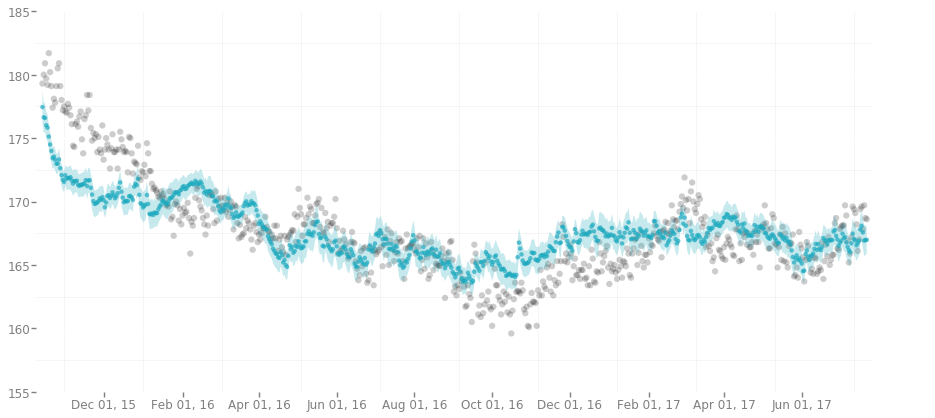

In [216]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=20) +\
geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.25, data=weight_pred_df) +\
scale_y_continuous(limits=(155, 185)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=15, height=7)

### Test set

In [159]:
weight_target = [ml_utils.weight_inverse_transform(x[0]) for x in target_test[:,-1]]
dates_target = [x + np.timedelta64(1, 'D') for x in dates_test[:,-1]]
days_target = list(range(len(dates_target)))
weight_target_df = pd.DataFrame({'day':days_target, 'date': dates_target, 'weight': weight_target})

(dates_target_min, dates_target_max) = (dates_target[0]-np.timedelta64(5,'D'), dates_target[-1]+np.timedelta64(5,'D'))

In [160]:
weight_pred_folds = []
for fold in range(len(models)):
    model = models[fold]
    rolling_sequence = features_test[0]
    weight_pred = []
    for t in range(1, len(dates_target)):
        pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
        weight_pred.append(pred)
        features_next = features_test[t][-1]
        features_next[0] = pred
#        rolling_sequence = features_test[t][0:(SEQUENCE_LENGTH-1)]
        rolling_sequence = rolling_sequence[1:SEQUENCE_LENGTH]
        rolling_sequence = np.append(rolling_sequence, np.array([features_next]), axis=0)
    final_pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
    weight_pred.append(final_pred)
    weight_pred = [ml_utils.weight_inverse_transform(x) for x in weight_pred]
    weight_pred_folds.append(weight_pred)

weight_pred_folds = np.array(weight_pred_folds).transpose()
weight_pred_mean = weight_pred_folds.mean(axis=1)
weight_pred_std = weight_pred_folds.std(axis=1)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'day':days_target, 'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

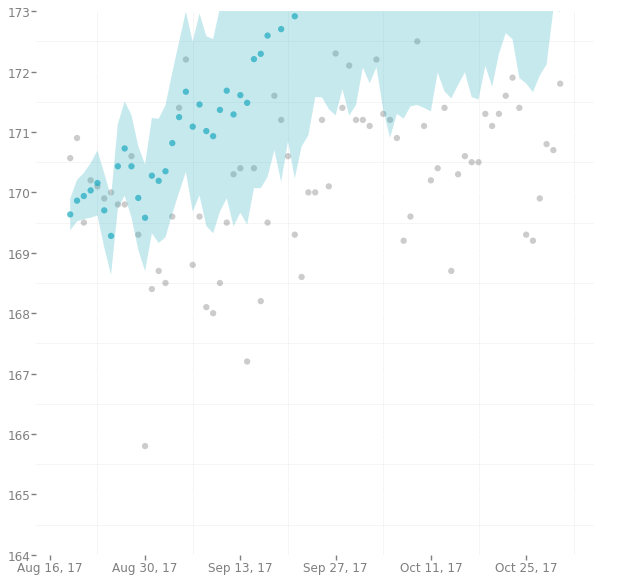

In [161]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=40) +\
geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.25, data=weight_pred_df) +\
scale_y_continuous(limits=(164, 173)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=10, height=10)

In [162]:
weight_pred_mean = []
weight_pred_std = []
rolling_sequence = features_test[0]
for t in range(1, len(dates_target)):
    weight_pred_folds = np.array([])
    for fold in range(len(models)):
        model = models[fold]
        pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
        weight_pred_folds = np.append(weight_pred_folds, pred)
    weight_mean = np.mean(weight_pred_folds)
    weight_std = np.std([ml_utils.weight_inverse_transform(x) for x in weight_pred_folds])
    weight_pred_mean.append(ml_utils.weight_inverse_transform(weight_mean))
    weight_pred_std.append(weight_std)
    features_next = features_test[t][-1]
    features_next[0] = weight_mean
#    rolling_sequence = features_test[t][0:(SEQUENCE_LENGTH-1)]
    rolling_sequence = rolling_sequence[1:SEQUENCE_LENGTH]
    rolling_sequence = np.append(rolling_sequence, np.array([features_next]), axis=0)

weight_pred_folds = np.array([])    
for fold in range(len(models)):
    model = models[fold]
    pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
    weight_pred_folds = np.append(weight_pred_folds, pred)
weight_mean = np.mean(weight_pred_folds)
weight_std = np.std([ml_utils.weight_inverse_transform(x) for x in weight_pred_folds])
weight_pred_mean.append(ml_utils.weight_inverse_transform(weight_mean))
weight_pred_std.append(weight_std)
weight_pred_mean = np.array(weight_pred_mean)
weight_pred_std = np.array(weight_pred_std)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

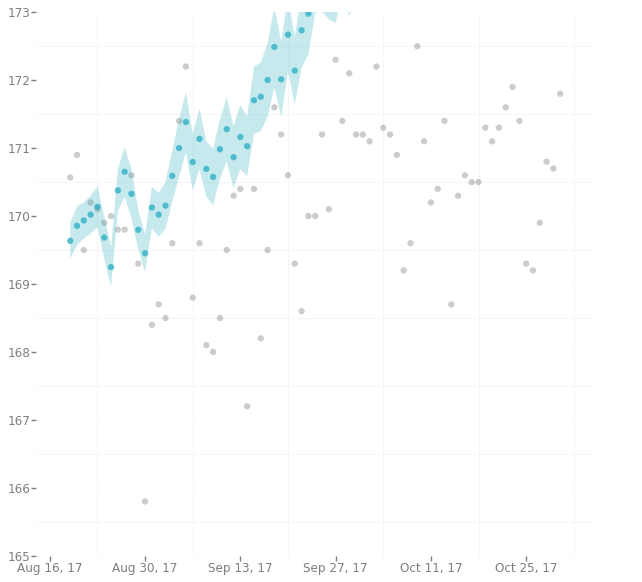

In [163]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=40) +\
geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.25, data=weight_pred_df) +\
scale_y_continuous(limits=(165, 173)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=10, height=10)

## 'What If' Predictions

In [217]:
def avg_model(seq):
    return np.mean([model.predict(np.array([seq]))[0][-1][0] for model in models])

In [221]:
cals = ml_utils.calories_transform(2000)
steps = ml_utils.steps_transform(8000)

seq = features_test[-1]
pred = []
dates = []
d = dates_test[-1][-1] + np.timedelta64(1, 'D')

for i in range(90):
    w = avg_model(seq)
    pred.append(ml_utils.weight_inverse_transform(w))
    dates.append(d)
    seq = np.array(seq[1:len(seq)])
    seq = np.append(seq, np.array([[w, steps, cals]]), axis=0)
    d = d + np.timedelta64(1, 'D')

In [222]:
pred[-1]

171.25221014022827

In [171]:
(dates_min, dates_max) = (dates[0]-np.timedelta64(5,'D'), dates[-1]+np.timedelta64(5,'D'))

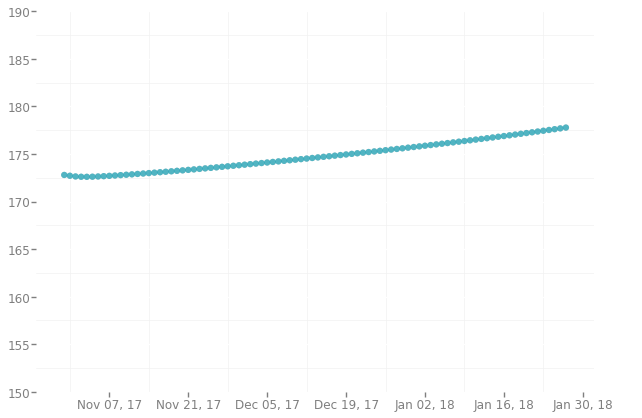

In [172]:
pred_df = pd.DataFrame({'date':dates, 'weight':pred})

p = ggplot(aes(x='date', y='weight'), data=pred_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=pred_df, color='#1DAABF', alpha=0.7, size=40) +\
scale_y_continuous(limits=(150, 190)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_min, dates_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=10, height=7)